In [1]:
import pandas as pd
import os
from datetime import datetime
import numpy as np
from tqdm import tqdm
from sklearn.metrics import fbeta_score, roc_auc_score, roc_curve, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
import neurokit2 as nk
import torch
from models.net_1d import Net1D
from data import ECG_Dataset

# 1. Data

In [ ]:
train_data = ECG_Dataset()
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=False,drop_last=True)    
test_data = ECG_Dataset(train=False,groups=[1,2,3])
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True,drop_last=True)    

In [ ]:
fig = plt.figure(figsize=(12,5))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=False,drop_last=True)    
for X,y in train_loader:
    X= X[13].numpy()
    print(X.shape)
    for i,lead in enumerate(X):
        plt.plot(lead+i*11)
    break

In [ ]:
def save_model(epochs, model, optimizer, criterion,name):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f'outputs/{name}.pth')

# 2. Model

In [4]:
# conv1d
def get_net_1d():
    base_filters = 64
    filter_list=[64,160,160,400,400,1024,1024]
    m_blocks_list=[2,2,2,3,3,4,4]  
    model = Net1D(
        in_channels=12, 
        base_filters=base_filters, 
        ratio=1.0, 
        filter_list=filter_list, 
        m_blocks_list=m_blocks_list, 
        kernel_size=16, 
        stride=2, 
        groups_width=16,
        verbose=False, 
        n_classes=1)
    return model

def get_net_2d():
    model = torchvision.models.resnet18(num_classes=1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=2,bias=False)
    return model


# 3. Training

In [ ]:
for exp in range(10):
    model = get_net_2d()
    EPOCHS = 6
    results = {'loss': [], 'val_loss': [], 'auc': [], 'val_auc': []}
    optim = torch.optim.Adam(model.parameters())
    loss = nn.MSELoss()
    best_auc = 0


    for epoch in range(EPOCHS):
        # training
        model.train()
        epoch_losses = []
        epoch_aucs = []
        for x, y in train_loader:
            x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
            yhat = model.forward(x)
            yhat = yhat.float()
            y = y.float()
            out = loss(yhat, y)
            optim.zero_grad()
            out.backward()
            optim.step()

            epoch_losses.append(out.item())
            fpr, tpr, _ = roc_curve( y.detach(),yhat.detach())
            roc_auc = auc(fpr, tpr)
            epoch_aucs.append(roc_auc)

        epoch_loss = np.mean(epoch_losses)
        epoch_auc = np.mean(epoch_aucs)

        # validation
        model.eval()
        epoch_val_losses = []
        epoch_val_aucs = []
        with torch.no_grad():
            for x, y in test_loader:
                x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
                yhat = model.forward(x)
                yhat = yhat.float()
                y = y.float()
                out = loss(yhat, y)
                epoch_val_losses.append(out.item())

                fpr, tpr, _ = roc_curve(y.detach(),yhat.detach())
                roc_auc = auc(fpr, tpr)
                epoch_val_aucs.append(roc_auc)

        epoch_val_loss = np.mean(epoch_val_losses)
        epoch_val_auc = np.mean(epoch_val_aucs)
        if epoch_val_auc>best_auc:
            best_auc = epoch_val_auc
            save_model(epochs=epoch,model=model,optimizer=optim,criterion=loss,name=f'best_model_exp_{exp}')
        # populate results
        results['loss'].append( epoch_loss )
        results['val_loss'].append( epoch_val_loss )
        results['auc'].append( epoch_auc )
        results['val_auc'].append( epoch_val_auc )

        #if (epoch+1) % 5 == 0 or epoch+1 == EPOCHS:
        print("Epoch {}/{}\tTrain Loss: {:.4f}\tTest Loss: {:.4f}\tTrain AUC: {:.2f} \tTest AUC: {:.2f} ".format(
                epoch+1, EPOCHS, epoch_loss, epoch_val_loss, epoch_auc, epoch_val_auc) )

In [ ]:
plt.plot(results['loss'],label='train')
plt.plot(results['auc'],label='val')
plt.xlabel("Epoch")

# 4. Evaluation

In [15]:
test_data={}
test_loader={}
for g in [1,2,3]:
    test_data[g] = ECG_Dataset(train=False,groups=[g])
    test_loader[g] = torch.utils.data.DataLoader(test_data[g], batch_size=32, shuffle=True,drop_last=True)    

In [19]:
suffix = datetime.now().strftime('%Y%m%d%H%M')
plt.figure()
ys ={}
preds = {}
c_dict = {
    1: 'b',
    2: 'r',
    3: 'g'
}

gname_dict = {
    1: 'Underweight_Normal',
    2: 'pre-obesity',
    3: 'obesity'
}

<Figure size 432x288 with 0 Axes>

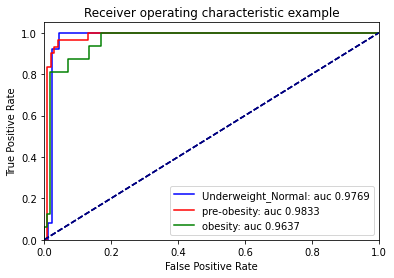

In [48]:
for g in [1,2,3]:
    ys[g] = []
    preds[g] = []
    for x, y in test_loader[g]:
        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
        yhat = model.forward(x)
        yhat = yhat.detach().numpy()
        y = y.detach().numpy()
        ys[g] = np.append(ys[g],y)
        preds[g] = np.append(preds[g],yhat)
    fpr, tpr, _ = roc_curve( ys[g],preds[g])
    roc_auc = auc(fpr, tpr)
    roc_auc = round(roc_auc,4)
    plt.plot(
        fpr,
        tpr,
        color=c_dict[g],
        label=f"{gname_dict[g]}: auc {roc_auc}",
    )
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()
# https://assets.researchsquare.com/files/rs-1550001/v1_covered.pdf?c=1650647458

In [16]:
aucs = {group:[] for group in [1,2,3]}
for exp in range(10):
    model = get_net_2d()
    checkpoint = torch.load(f"outputs/best_model_exp_{exp}.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    for g in [1,2,3]:
        ys = []
        preds = []
        for x, y in test_loader[g]:
            x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
            yhat = model.forward(x)
            yhat = yhat.detach().numpy()
            y = y.detach().numpy()
            ys = np.append(ys,y)
            preds = np.append(preds,yhat)
        fpr, tpr, _ = roc_curve( ys,preds)
        roc_auc = auc(fpr, tpr)
        aucs[g].append(roc_auc)

In [41]:
odds_table = pd.DataFrame(index=[gname_dict[g] for g in [1,2,3]],columns=[f"Rank {g}" for g in [1,2,3]]).fillna(0)
for exp in range(10):
    auc_exp = [aucs[g][exp] for g in [1,2,3]]
    ranks = sorted(range(len(auc_exp))[::-1], key=lambda k: auc_exp[k])[::-1]
    for r in [1,2,3]:
        odds_table.loc[gname_dict[ranks[r-1]+1],f"Rank {r}"]+=1
odds_table/10

,Rank 1,Rank 2,Rank 3
Underweight_Normal,0.7,0.2,0.1
pre-obesity,0.3,0.7,0.0
obesity,0.0,0.1,0.9


<Figure size 432x288 with 0 Axes>

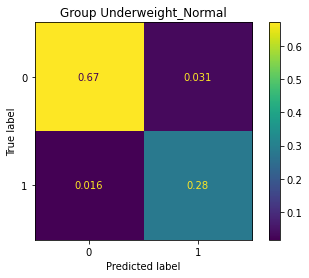

<Figure size 432x288 with 0 Axes>

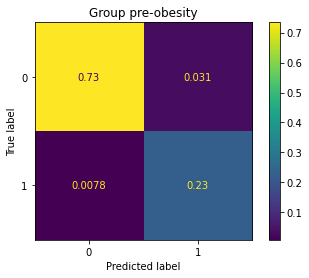

<Figure size 432x288 with 0 Axes>

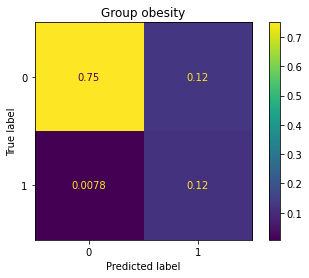

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for g in [1,2,3]:
    plt.figure()
    y = ys[g]
    pred = preds[g]
    pred = [0 if p<pred.mean() else 1 for p in pred]
    cm = confusion_matrix(y, pred, normalize='all')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Group {gname_dict[g]}")

In [ ]:
# https://neurokit2.readthedocs.io/en/latest/examples/heartbeats.html
rpeaks = info["ECG_R_Peaks"]
cleaned_ecg = df["ECG_Clean"]
plot = nk.events_plot(rpeaks, cleaned_ecg)